<a href="https://colab.research.google.com/github/AvivShuster/Data-Science-Competitions/blob/main/RSNA_pneumonia_detection_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import random
import gc
import pydicom
import pylab
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras

from skimage import io
from skimage import measure
from skimage.transform import resize

import warnings
warnings.simplefilter(action = "ignore")

In [ ]:
ls ../input/rsna-pneumonia-detection-challenge/

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images/
 stage_2_detailed_class_info.csv        stage_2_train_images/
 stage_2_sample_submission.csv          stage_2_train_labels.csv


In [ ]:
train_labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
detailed_class_info = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [ ]:
train_labels.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
detailed_class_info.head(5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Thease two datasets give information about the bounding boxes of Lung Opacityes and the labeld targets.
Therefore, i will merge them to a single dataframe:

In [ ]:
df_train = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = "patientId")

In [ ]:
df_train.head(5)

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [ ]:
del detailed_class_info, train_labels
gc.collect()

98

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  37629 non-null  object 
 1   class      37629 non-null  object 
 2   x          16957 non-null  float64
 3   y          16957 non-null  float64
 4   width      16957 non-null  float64
 5   height     16957 non-null  float64
 6   Target     37629 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
df_train = df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
df_train.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [ ]:
df_train.dtypes

patientId     object
class         object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object

Now, we will check if there are patients which have multiple rows, and figure out the scale:

In [ ]:
df_train['patientId'].value_counts().unique()

array([4, 3, 2, 1])

So it seems that there are patients which have 4 different bboxes of Lung Opacities in their Radiography image.

In [ ]:
df_train['patientId'].value_counts().head(1)

3239951b-6211-4290-b237-3d9ad17176db    4
Name: patientId, dtype: int64

An example:

In [ ]:
df_train[df_train['patientId'] == '3239951b-6211-4290-b237-3d9ad17176db']

,patientId,class,x,y,width,height,Target
3411,3239951b-6211-4290-b237-3d9ad17176db,Lung Opacity,511.0,249.0,188.0,232.0,1
3412,3239951b-6211-4290-b237-3d9ad17176db,Lung Opacity,558.0,649.0,174.0,186.0,1
3413,3239951b-6211-4290-b237-3d9ad17176db,Lung Opacity,152.0,661.0,191.0,145.0,1
3414,3239951b-6211-4290-b237-3d9ad17176db,Lung Opacity,198.0,370.0,204.0,205.0,1


In [ ]:
df_train['patientId'].value_counts().value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [ ]:
df_train[df_train['Target'] == 1]['patientId'].value_counts().value_counts()

2    3266
1    2614
3     119
4      13
Name: patientId, dtype: int64

Most of the patients, who has a Pneumonia, has a single bbox of Lung Opacity in their Radiography image.

In [ ]:
df_train[df_train['Target'] == 0]['patientId'].value_counts().value_counts()

1    20672
Name: patientId, dtype: int64

All of the patients, who does not have a Pneumonia, have only one row in the dataset.

In [ ]:
df_train.head(1)

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0


In [ ]:
print(df_train.isna().sum().sort_values(ascending = False))

x            20672
y            20672
width        20672
height       20672
patientId        0
class            0
Target           0
dtype: int64


# EDA

### Exploring the Target Feature

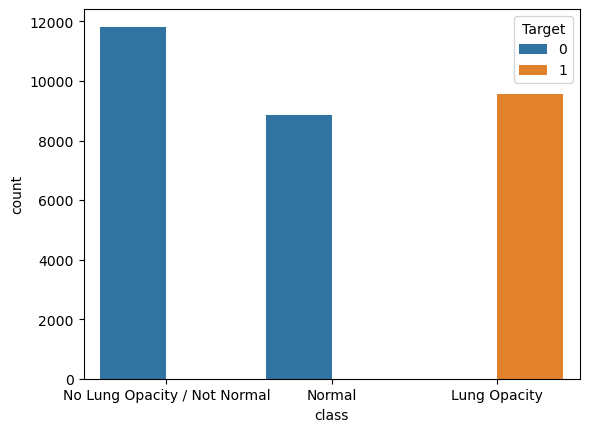

In [ ]:
sns.countplot(x = 'class', hue = 'Target', data = df_train);

"No Lung Capacity / Not normal", is when the Radiography image contains abnormal behavior - other Opacities which are not Pneumonia related.<br>
Therefore, it is labeld as not a Pneumonia disease == 0 (Target value).<br>
A patient has a Pneumonia if class == Lung Opacity. 

In [ ]:
df_train[df_train['class'] == 'Lung Opacity']['Target'].value_counts(dropna = False) # The Pneumonia Disease

1    9555
Name: Target, dtype: int64

In [ ]:
df_train[df_train['class'] == 'No Lung Opacity / Not Normal']['Target'].value_counts(dropna = False) # Not a Pneumonia Disease

0    11821
Name: Target, dtype: int64

In [ ]:
df_train[df_train['class'] == 'Normal']['Target'].value_counts(dropna = False) # Not a Pneumonia Disease

0    8851
Name: Target, dtype: int64

### Exploring the Spatial Features of the Radiography image

There are 4 dimensions that define the bounding boxes in an image: **x, y, width, height**.

In [ ]:
df_dimensions = df_train.dropna()[['x', 'y', 'width', 'height']].copy()

In [ ]:
df_dimensions['x_center'] = df_dimensions['x'] + df_dimensions['width'] / 2
df_dimensions['y_center'] = df_dimensions['y'] + df_dimensions['height'] / 2
df_dimensions['x2'] = df_dimensions['x'] + df_dimensions['width']
df_dimensions['y2'] = df_dimensions['y'] + df_dimensions['height']
df_dimensions['area'] = df_dimensions['width'] * df_dimensions['height']

In [ ]:
df_dimensions.head()

,x,y,width,height,x_center,y_center,x2,y2,area
4,264.0,152.0,213.0,379.0,370.5,341.5,477.0,531.0,80727.0
5,562.0,152.0,256.0,453.0,690.0,378.5,818.0,605.0,115968.0
10,323.0,577.0,160.0,104.0,403.0,629.0,483.0,681.0,16640.0
11,695.0,575.0,162.0,137.0,776.0,643.5,857.0,712.0,22194.0
18,288.0,322.0,94.0,135.0,335.0,389.5,382.0,457.0,12690.0


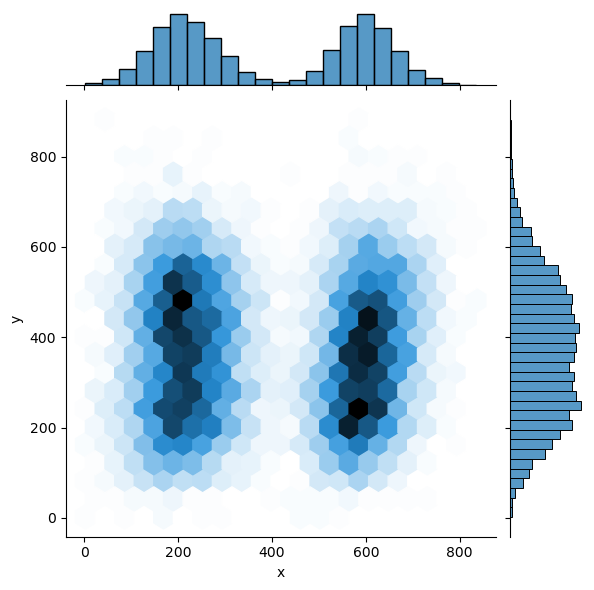

In [ ]:
sns.jointplot(x = 'x', y = 'y', data = df_dimensions, kind = 'hex', gridsize = 20)

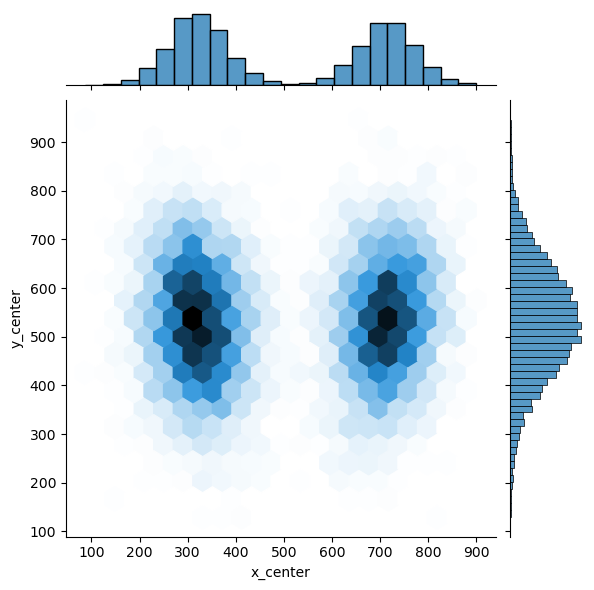

In [ ]:
sns.jointplot(x = 'x_center', y = 'y_center', data = df_dimensions, kind = 'hex', gridsize = 20)

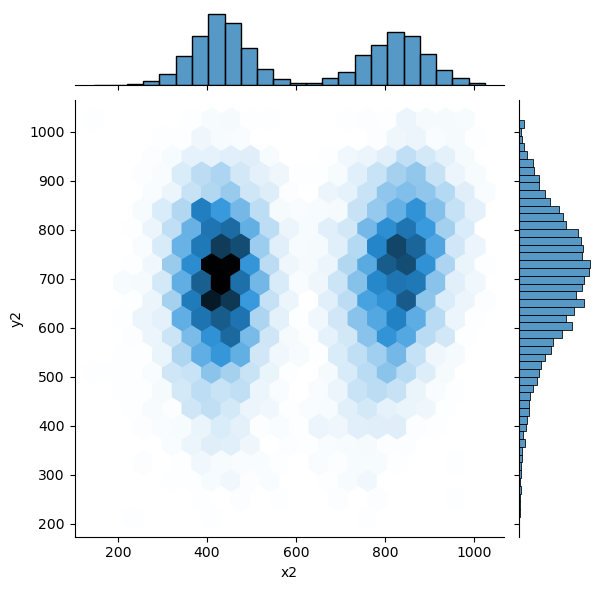

In [ ]:
sns.jointplot(x = 'x2', y = 'y2', data = df_dimensions, kind = 'hex', gridsize = 20)

The opposite corners and the centers have **smaller variance** than the main corners (x,y), and they have **small correlation**.<br>
Therefore, there is no reason to replace the main corners with any of the points.


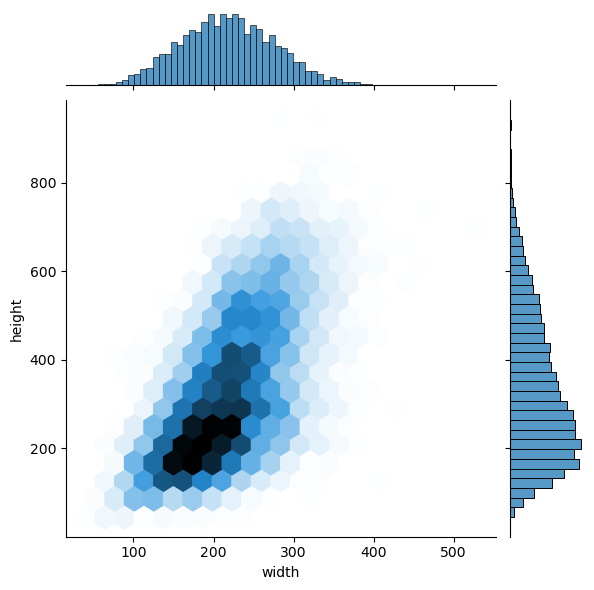

In [ ]:
sns.jointplot(x = 'width', y = 'height', data = df_dimensions, kind = 'hex', gridsize = 20)

It seems that **height** and **width** have a high correlation.

Now, we will look for outliers in the different variables:

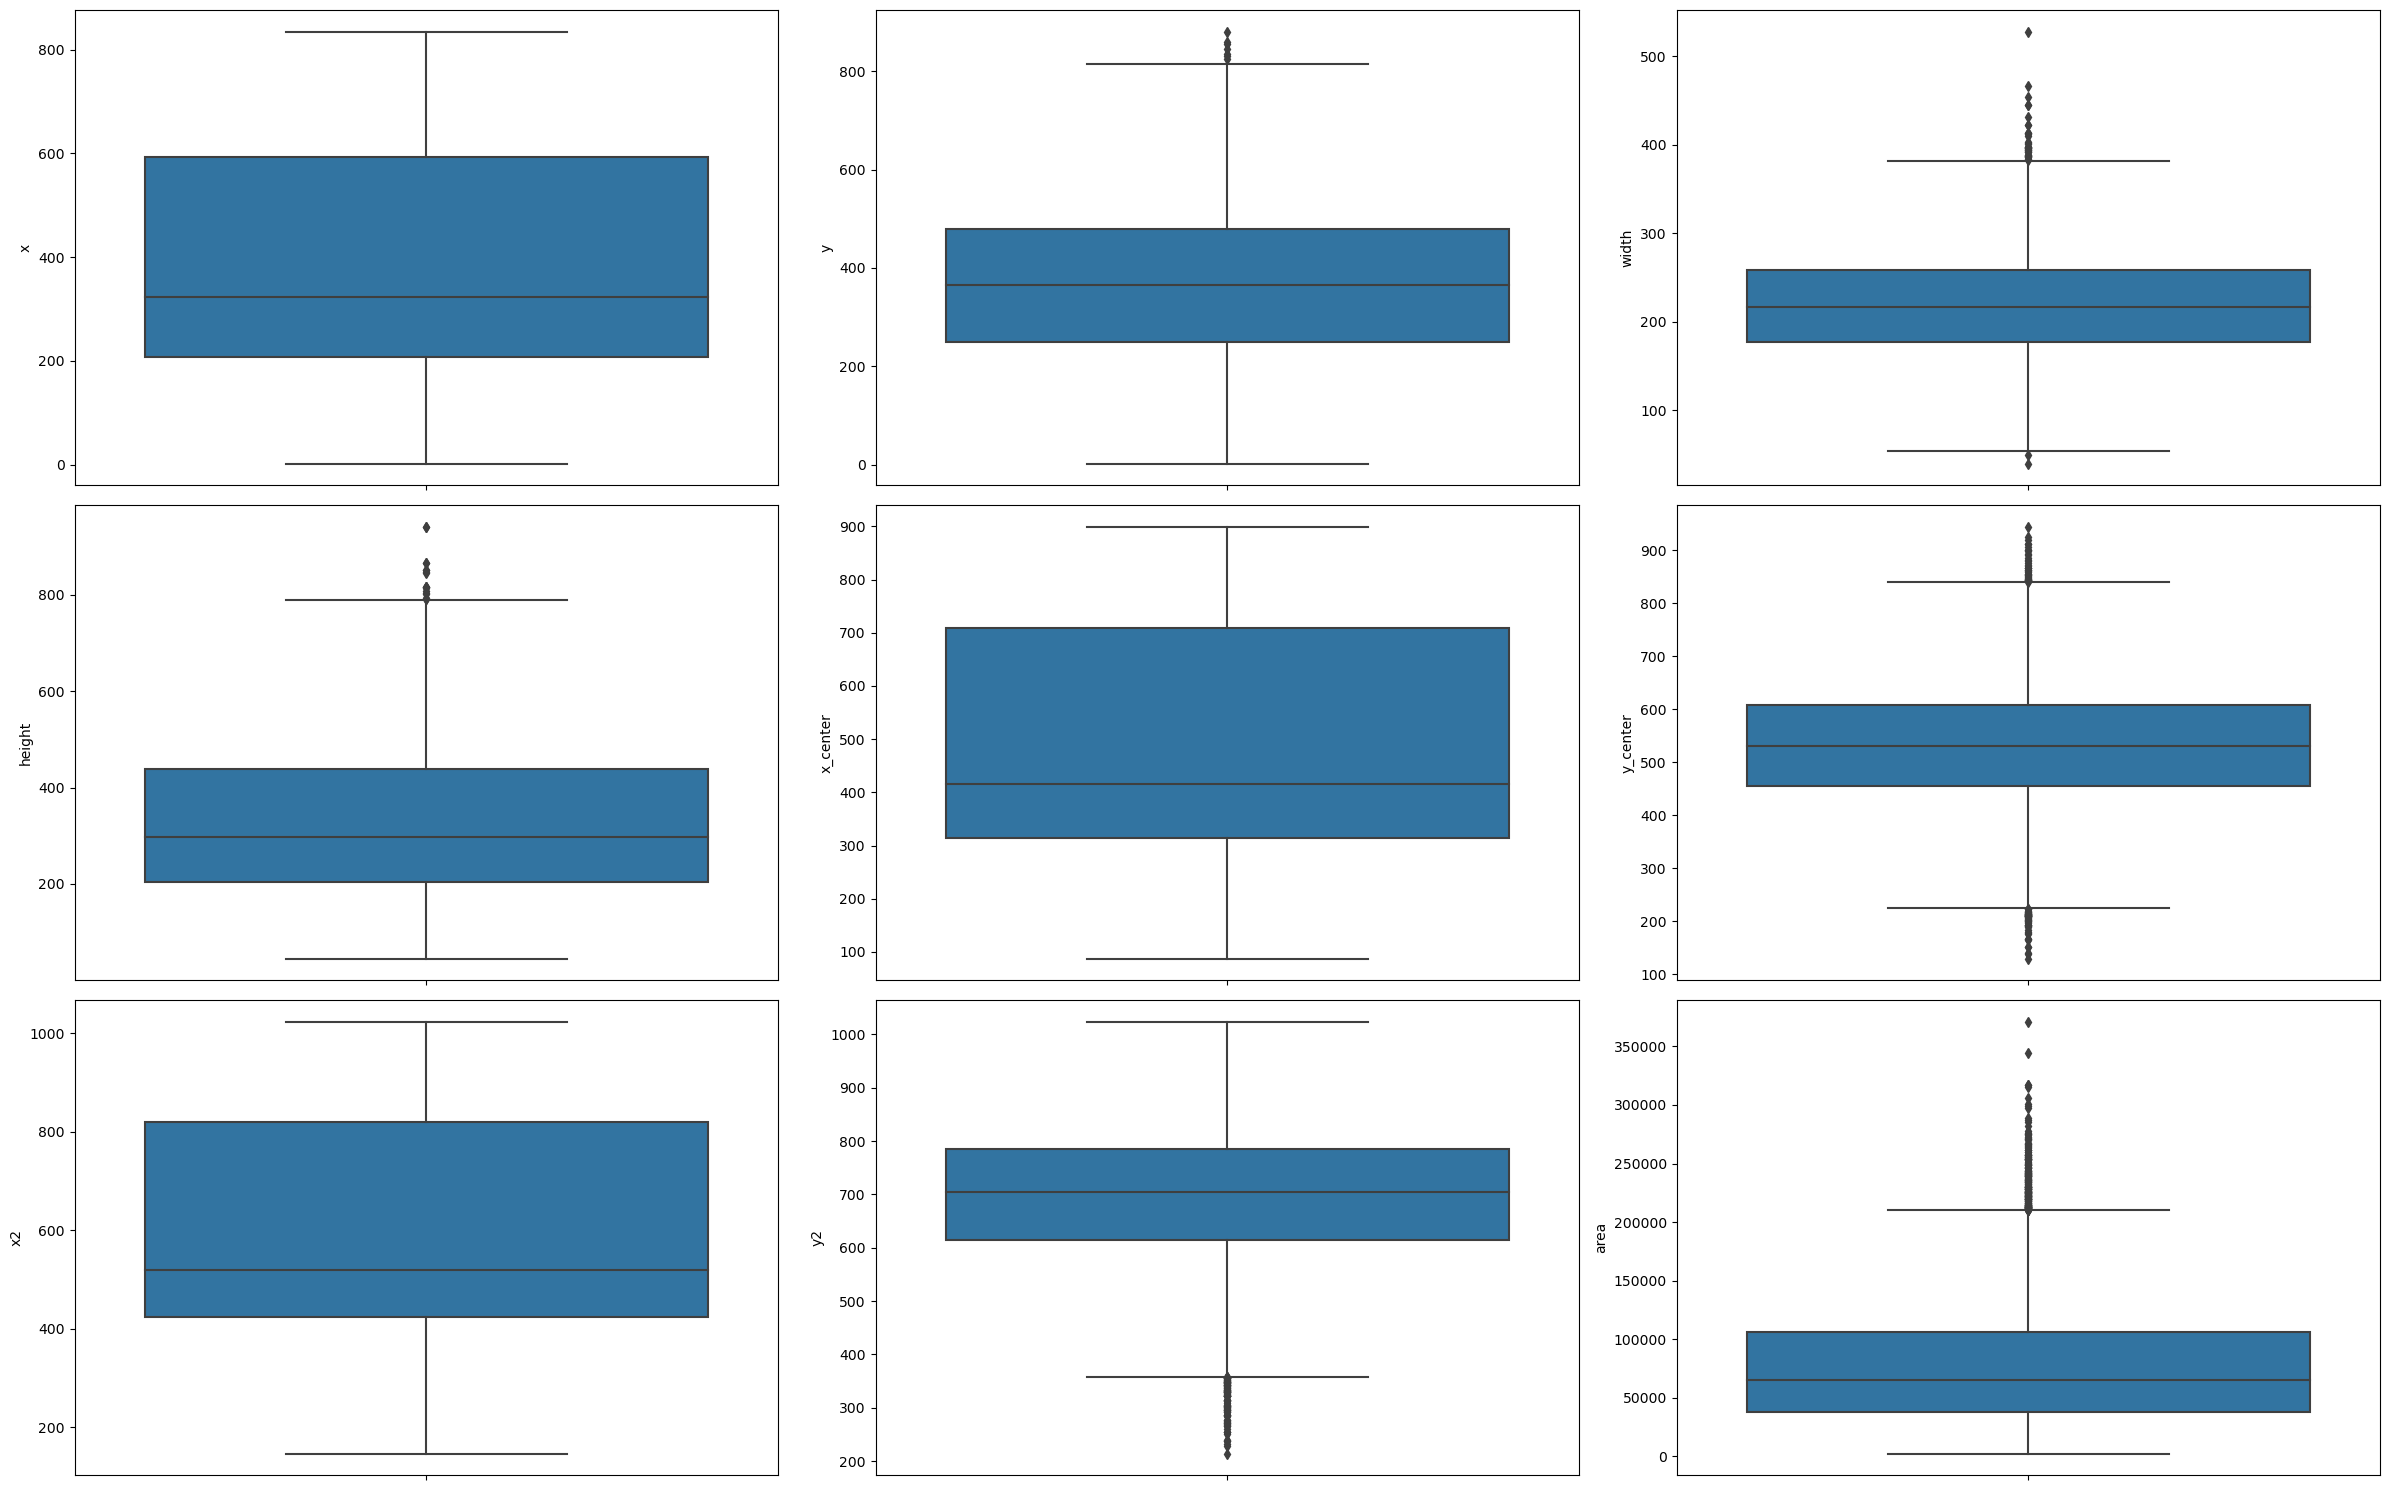

In [ ]:
n_columns = 3
n_rows = 3
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(df_dimensions.columns):
    sns.boxplot(y = c, data = df_dimensions, ax = axes[i // n_columns, i % n_columns]) # // means floor division
plt.tight_layout()
plt.show()

Is seems that there are some outliers in width, height and area.<br>
Let's explore thease:

In [ ]:
df_dimensions[df_dimensions['height'] > 900]

,x,y,width,height,x_center,y_center,x2,y2,area
5792,549.0,82.0,280.0,942.0,689.0,553.0,829.0,1024.0,263760.0
6186,620.0,82.0,335.0,942.0,787.5,553.0,955.0,1024.0,315570.0


In [ ]:
patientId_height = list(df_train[df_train['height'] > 900]['patientId'])
df_train[df_train['patientId'].isin(patientId_height)]

,patientId,class,x,y,width,height,Target
5791,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,Lung Opacity,87.0,104.0,310.0,793.0,1
5792,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,Lung Opacity,549.0,82.0,280.0,942.0,1
6185,3e62e51c-befb-4a66-b28e-fc469b19e4a8,Lung Opacity,148.0,87.0,366.0,867.0,1
6186,3e62e51c-befb-4a66-b28e-fc469b19e4a8,Lung Opacity,620.0,82.0,335.0,942.0,1


In [ ]:
df_dimensions[df_dimensions['width'] > 500]

,x,y,width,height,x_center,y_center,x2,y2,area
928,226.0,189.0,528.0,703.0,490.0,540.5,754.0,892.0,371184.0


In [ ]:
patientId_width = list(df_train[df_train['width'] > 500]['patientId'])
df_train[df_train['patientId'].isin(patientId_width)]

,patientId,class,x,y,width,height,Target
928,097788d4-cb88-4457-8e71-0ca7a3da2216,Lung Opacity,226.0,189.0,528.0,703.0,1


It seems that there are 3 patients who are outliers.<br> I will remove thease rows:

In [ ]:
rows_to_drop = df_train['patientId'].isin(patientId_width + patientId_height)

In [ ]:
df_train[rows_to_drop]

,patientId,class,x,y,width,height,Target
928,097788d4-cb88-4457-8e71-0ca7a3da2216,Lung Opacity,226.0,189.0,528.0,703.0,1
5791,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,Lung Opacity,87.0,104.0,310.0,793.0,1
5792,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,Lung Opacity,549.0,82.0,280.0,942.0,1
6185,3e62e51c-befb-4a66-b28e-fc469b19e4a8,Lung Opacity,148.0,87.0,366.0,867.0,1
6186,3e62e51c-befb-4a66-b28e-fc469b19e4a8,Lung Opacity,620.0,82.0,335.0,942.0,1


In [ ]:
df_train.drop(df_train[rows_to_drop].index,inplace = True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30222 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30222 non-null  object 
 1   class      30222 non-null  object 
 2   x          9550 non-null   float64
 3   y          9550 non-null   float64
 4   width      9550 non-null   float64
 5   height     9550 non-null   float64
 6   Target     30222 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
df_train.shape

(30222, 7)

### Exploring the meta information in the DICOM files

In [ ]:
pid = df_train['patientId'][0]
dcm_file = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
img = dcm_data.pixel_array
print(type(img))
print(img.dtype)
print(img.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


The pixel array data is stored as a **Numpy array**.<br>
The original images have been rescaled to **8-bit encoding** (256 levels of gray).<br>
The dimensions of a Radiography image was resized to **1024x1024**. 

### Visualizing an example of a DICOM image

(-0.5, 1023.5, 1023.5, -0.5)

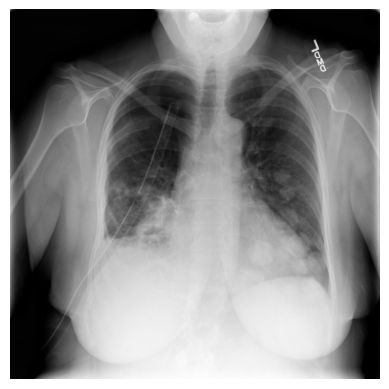

In [ ]:
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...
        
      }

    """
    # Define lambda to extract coordinates in a list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {} # A dictionary to save the parsed CSV's data 
    for n, row in df_train.iterrows():
        # Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # Add box if a Lung Opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [ ]:
parsed = parse_data(df_train)

for an example, lets print the parsed data of the first patient with Lung Opacity:

In [ ]:
df_train[df_train['class'] == 'Lung Opacity'].head(1)

,patientId,class,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [ ]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


### Visualizing boxes

In [ ]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # Open DICOM file
    dicom = pydicom.read_file(data['dicom'])
    img = dicom.pixel_array

    # Convert from single-channel grayscale to 3-channel RGB
    img = np.stack([img] * 3, axis=2)

    # Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        img = overlay_box(img=img, box=box, rgb=rgb, stroke=6)

    pylab.imshow(img, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(img, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # Convert coordinates to integers
    box = [int(b) for b in box]
    
    # Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    img[y1:y1 + stroke, x1:x2] = rgb
    img[y2:y2 + stroke, x1:x2] = rgb
    img[y1:y2, x1:x1 + stroke] = rgb
    img[y1:y2, x2:x2 + stroke] = rgb

    return img

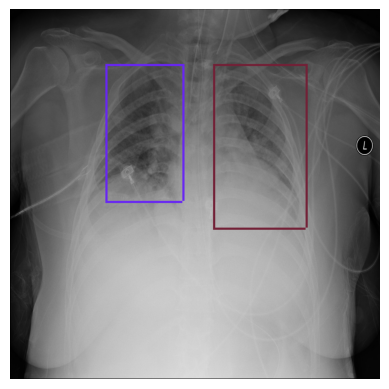

In [ ]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

### Exploring detailed labels

In [ ]:
detailed_class_info = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [ ]:
print(detailed_class_info.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


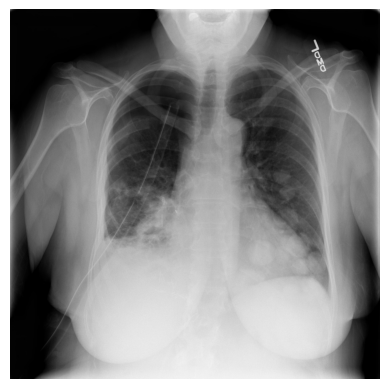

In [ ]:
patientId = detailed_class_info['patientId'][0]
draw(parsed[patientId])

In [ ]:
summary = {}
for n, row in detailed_class_info.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 9555}


# Data generator + Network


### Load Opacities locations

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary, which contains a list of pneumonia locations per filename
        if pneumonia == '1': # Target=1
            # convert string to float, and then to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

### Split Train set to Train and Valid

In [ ]:
# load and shuffle filenames
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into Train and Validation filenames
n_valid_samples = 2560 # number of Validation samples
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('Number of Train samples:', len(train_filenames))
print('Number of Valid samples:', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

Number of Train samples: 24124
Number of Valid samples: 2560


### Data generator

In [ ]:
class dataGen(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations = None, batch_size = 32, image_size = 256, shuffle = True, augment = False, predict = False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        
    def __load__(self, filename):
        # load DICOM file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains Pneumonia Opacity
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1 # padding the Pneumonia Opacity area with '1's
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect') # The mode reflect, determines that the array borders are reflected by the previous ones
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5 # the mask will bre reflected ant not zero bounded, half of the time
        # if augment, then make horizontal flips, half of the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img) # reverse the order of elements along axis 1 (left/right - horizontal flip).
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load DICOM file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode (return images and filenames)
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode (return images and masks)
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
           
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

### Network

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs) # Momentum helps in reducing the noise in gradient update term and thus helps to converge faster to the optimal (or near optimal) value.
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs]) # adding the skipped connection as in Resblock - It’s a way to avoid gradient diffusion. It’s like the differential coefficient plus 1, even if the original one is small, the error can still be backpropagated.

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x) # Repeats the rows and columns of the data by 2 to power of the input size.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# define IOU loss function
# Intersection over Union (IOU) based losses: bbox regression uses overlap area between the predicted bounding box and the ground truth bounding box.
def iou_loss(y_true, y_pred):
    y_true = float(tf.reshape(y_true, [-1]) == True)
    y_pred = tf.reshape(y_pred, [-1])
    #print(int(y_true == True))
    intersection = tf.reduce_sum(y_true * y_pred) # Computes the sum of elements multiplications, across dimensions of the tensor (when there will be no overlap between boxes, intersection == 0)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.) 
    return 1 - score # IOU = (Intersection)/(Union)

# combine Binary cross-entropy loss and IOU loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean IOU as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_generator = dataGen(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_generator = dataGen(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_generator, validation_data=valid_generator, callbacks=[learning_rate], epochs=20, workers=4, use_multiprocessing=True)

Epoch 1/20
753/753 [==============================] - 1745s 2s/step - loss: 0.4916 - accuracy: 0.9587 - mean_iou: 0.6141 - val_loss: 0.5207 - val_accuracy: 0.9246 - val_mean_iou: 0.4680 - lr: 0.0010
Epoch 2/20
753/753 [==============================] - 1788s 2s/step - loss: 0.4459 - accuracy: 0.9666 - mean_iou: 0.6666 - val_loss: 0.4418 - val_accuracy: 0.9750 - val_mean_iou: 0.7432 - lr: 9.9384e-04
Epoch 3/20
753/753 [==============================] - 1727s 2s/step - loss: 0.4322 - accuracy: 0.9686 - mean_iou: 0.6828 - val_loss: 0.4628 - val_accuracy: 0.9755 - val_mean_iou: 0.7500 - lr: 9.7553e-04
Epoch 4/20
753/753 [==============================] - 1751s 2s/step - loss: 0.4237 - accuracy: 0.9695 - mean_iou: 0.6921 - val_loss: 0.5100 - val_accuracy: 0.9718 - val_mean_iou: 0.6456 - lr: 9.4550e-04
Epoch 5/20
753/753 [==============================] - 1780s 2s/step - loss: 0.4172 - accuracy: 0.9700 - mean_iou: 0.6946 - val_loss: 0.4212 - val_accuracy: 0.9739 - val_mean_iou: 0.7034 - lr: 

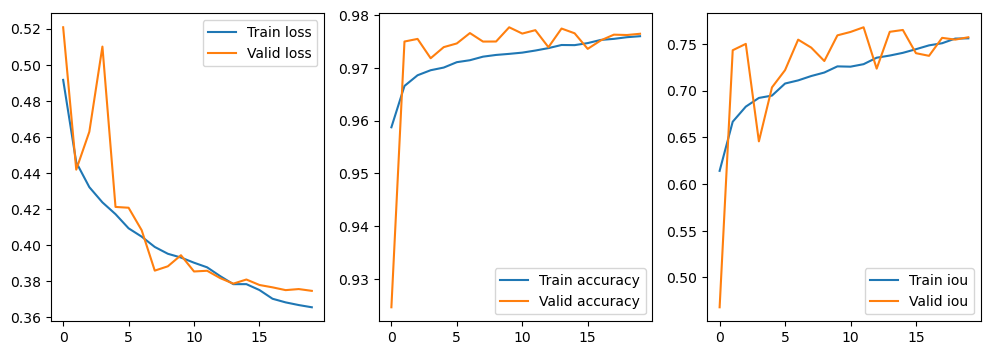

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


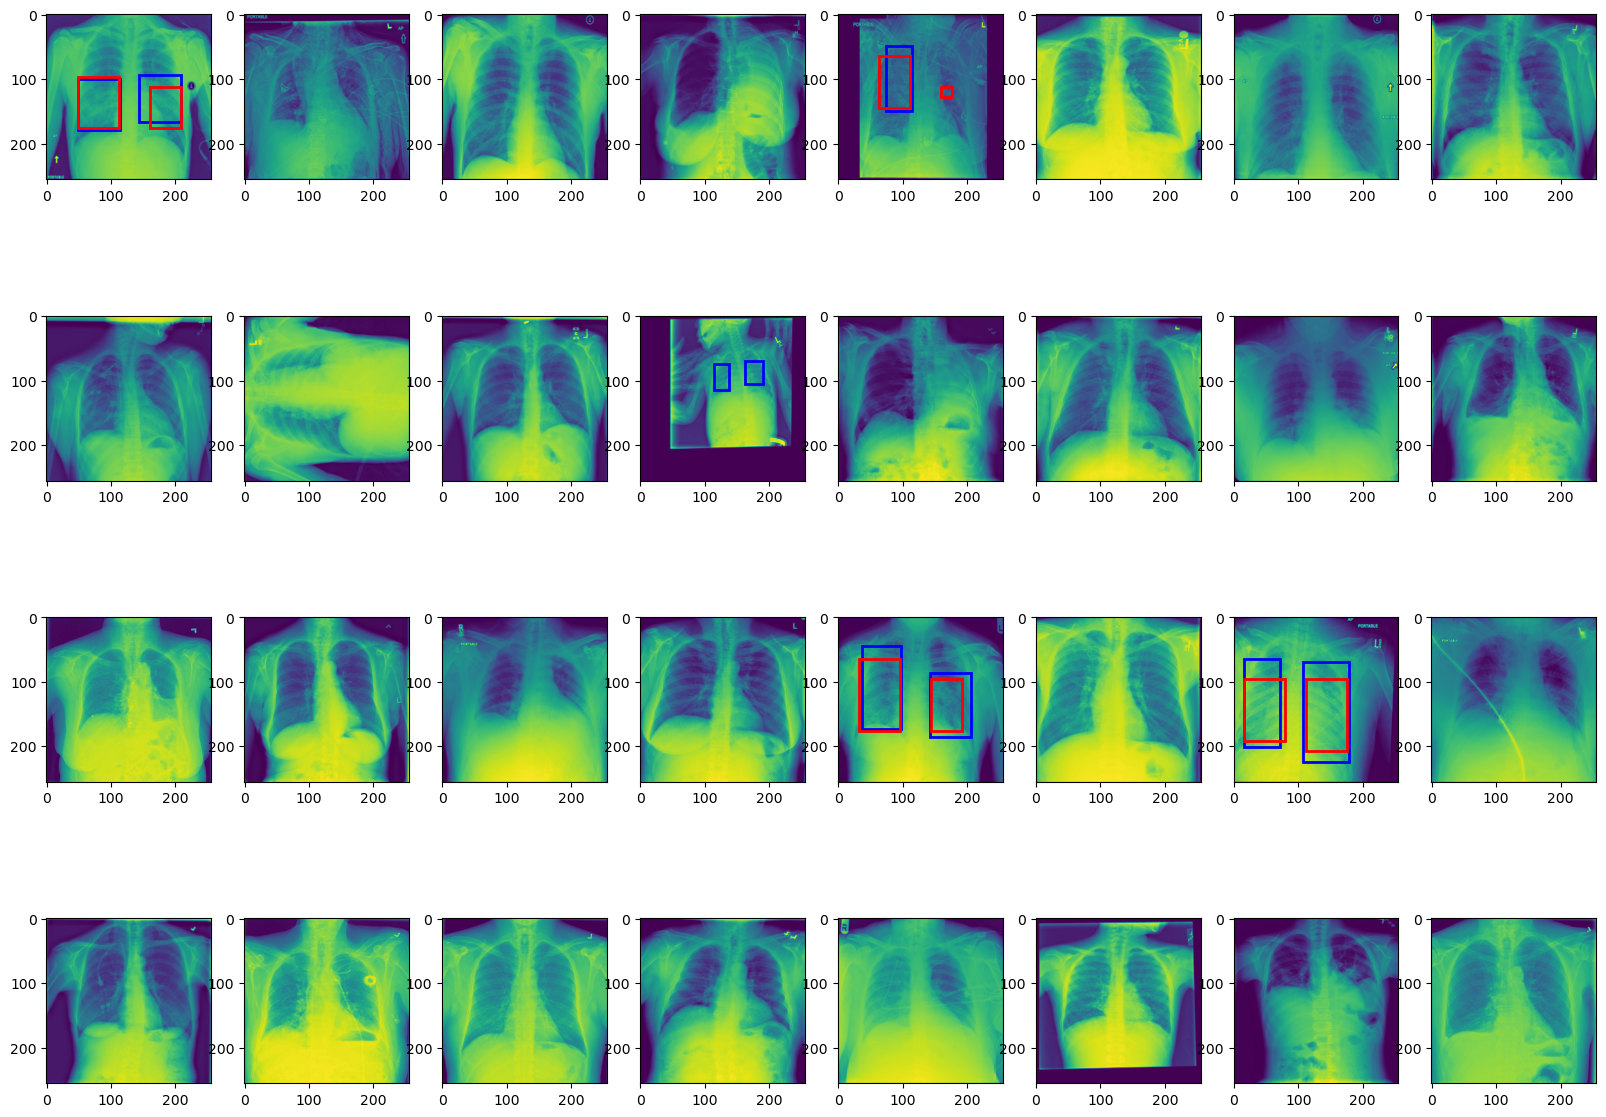

In [ ]:
for imgs, msks in valid_generator:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel() # flattning the numpy array
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp) # "1 or 2 connectivity" forms of connections with the mask
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

# Predict test images

In [ ]:
# load and shuffle filenames
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_generator = dataGen(folder, test_filenames, None, batch_size=20, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_generator:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000
1/1 [==============================] - 0s 25ms/step


In [ ]:
print(sub)

                                                                       PredictionString
patientId                                                                              
12abc170-f1fe-45d3-b574-2f4d030e40cd                                                   
2abcf934-facd-40fc-a75e-0062441fd206  0.9067156 192 256 194 447 0.8205642 512 257 25...
2da69f80-c59d-4e4a-b7e5-1d631ef4186b                                                   
13e4e6e6-faa2-4bbc-8e1e-610623de994e                                                   
2afe02a3-06da-42fa-b68f-3e9c921e5fb9                                                   
...                                                                                 ...
1ef2bfbf-b68d-4981-8dc3-b5d7b54ad55e                                                   
1fc3831a-7b78-48c5-90c1-af8971ee9eae  0.5548974 704 321 62 64 0.60090786 577 383 63 64 
20da1944-1714-4170-a08a-8b82c0788ad5                                                   
13c6a303-2c21-4edf-9dca-4999dafe